# Gathering clusters from the data
#### In this document, our team's goal is to cluster textual data from Reddit's r/Politics subreddit.
> Using unsupervised machine learning techniques we will attempt to describe the potential meaning behind the clustering of the data.

In [8]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

from sklearn.metrics import silhouette_samples, silhouette_score

from scipy.interpolate import make_interp_spline
from scipy.signal import argrelmax

In [9]:
# pd.set_option("max_colwidth", 800)

In [10]:
upvoted = pd.read_csv("data/scraped-data/large_upvoted.csv",index_col=0)
downvoted = pd.read_csv("data/scraped-data/large_downvoted.csv", index_col=0)
posts = pd.read_csv("data/scraped-data/politics_posts_2020.csv", index_col=0)

## Combining both upvoted and downvoted comments into one dataframe

In [11]:
comments = pd.concat([upvoted, downvoted]).drop(columns=['Author'])
comments = comments.reset_index(drop=True)
comments.sort_values(by="score", ascending=False)

,comment,score
0,Congrats on President elect Joe Biden for winn...,21260
1,The level of narcissism it takes to think that...,19822
2,Fuck,19726
3,Direct quote from this guy Redistricting is li...,18723
4,Are you telling me that a cyber security speci...,17778
...,...,...
1464,Thank you for your comment We will take Americ...,-280
1463,My point is that all politicians are corrupt W...,-282
1462,So is the Democratic Party,-307
1461,The original incident was not worth responding...,-390


## Building our model
> Our model consists of a TFIF Vectorizer, with no limit of features. This will create as much features as there needs to be to vectorize all the text in the available data. <br>
> The data will then pass through a PCA to reduce dimentions do 3, so that we are able to assign a visual 3 dimentional representation to our clusters. <br>
> Finally, the data is passed to a KMeans algorithm to attribule clusters to the different points in the data.<br>

In [12]:
transform_steps = [
    # Create Tfidf vectorization on comments
    ('tfidf', TfidfVectorizer())
    ,("to_array", FunctionTransformer(lambda x: x.todense(), accept_sparse=True))
    
    # Reducing the dimension to 3 with PCA
    ,('reduce_dim', PCA(3))
]

cluster_steps = [
    ('kmean', KMeans(n_clusters = 4, random_state=0))
]

transform_pipe = Pipeline(transform_steps)
cluster_pipe = Pipeline(cluster_steps)

In [13]:
def generate_model(x, ret_clu = True):
    transform = transform_pipe.fit_transform(x)
    cluster = cluster_pipe.fit(transform)
    
    if not ret_clu:
        return transform,
    return transform, cluster

def generate_df(df, transform, cluster, string):
    pca = pd.DataFrame(transform, columns=['pca1','pca2','pca3'])
    pca['label'] = cluster['kmean'].labels_
    pca['text'] = df[string]
    pca['score'] = df['score']
    return pca

## Silouhette analysis for comments

/home/pavel/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


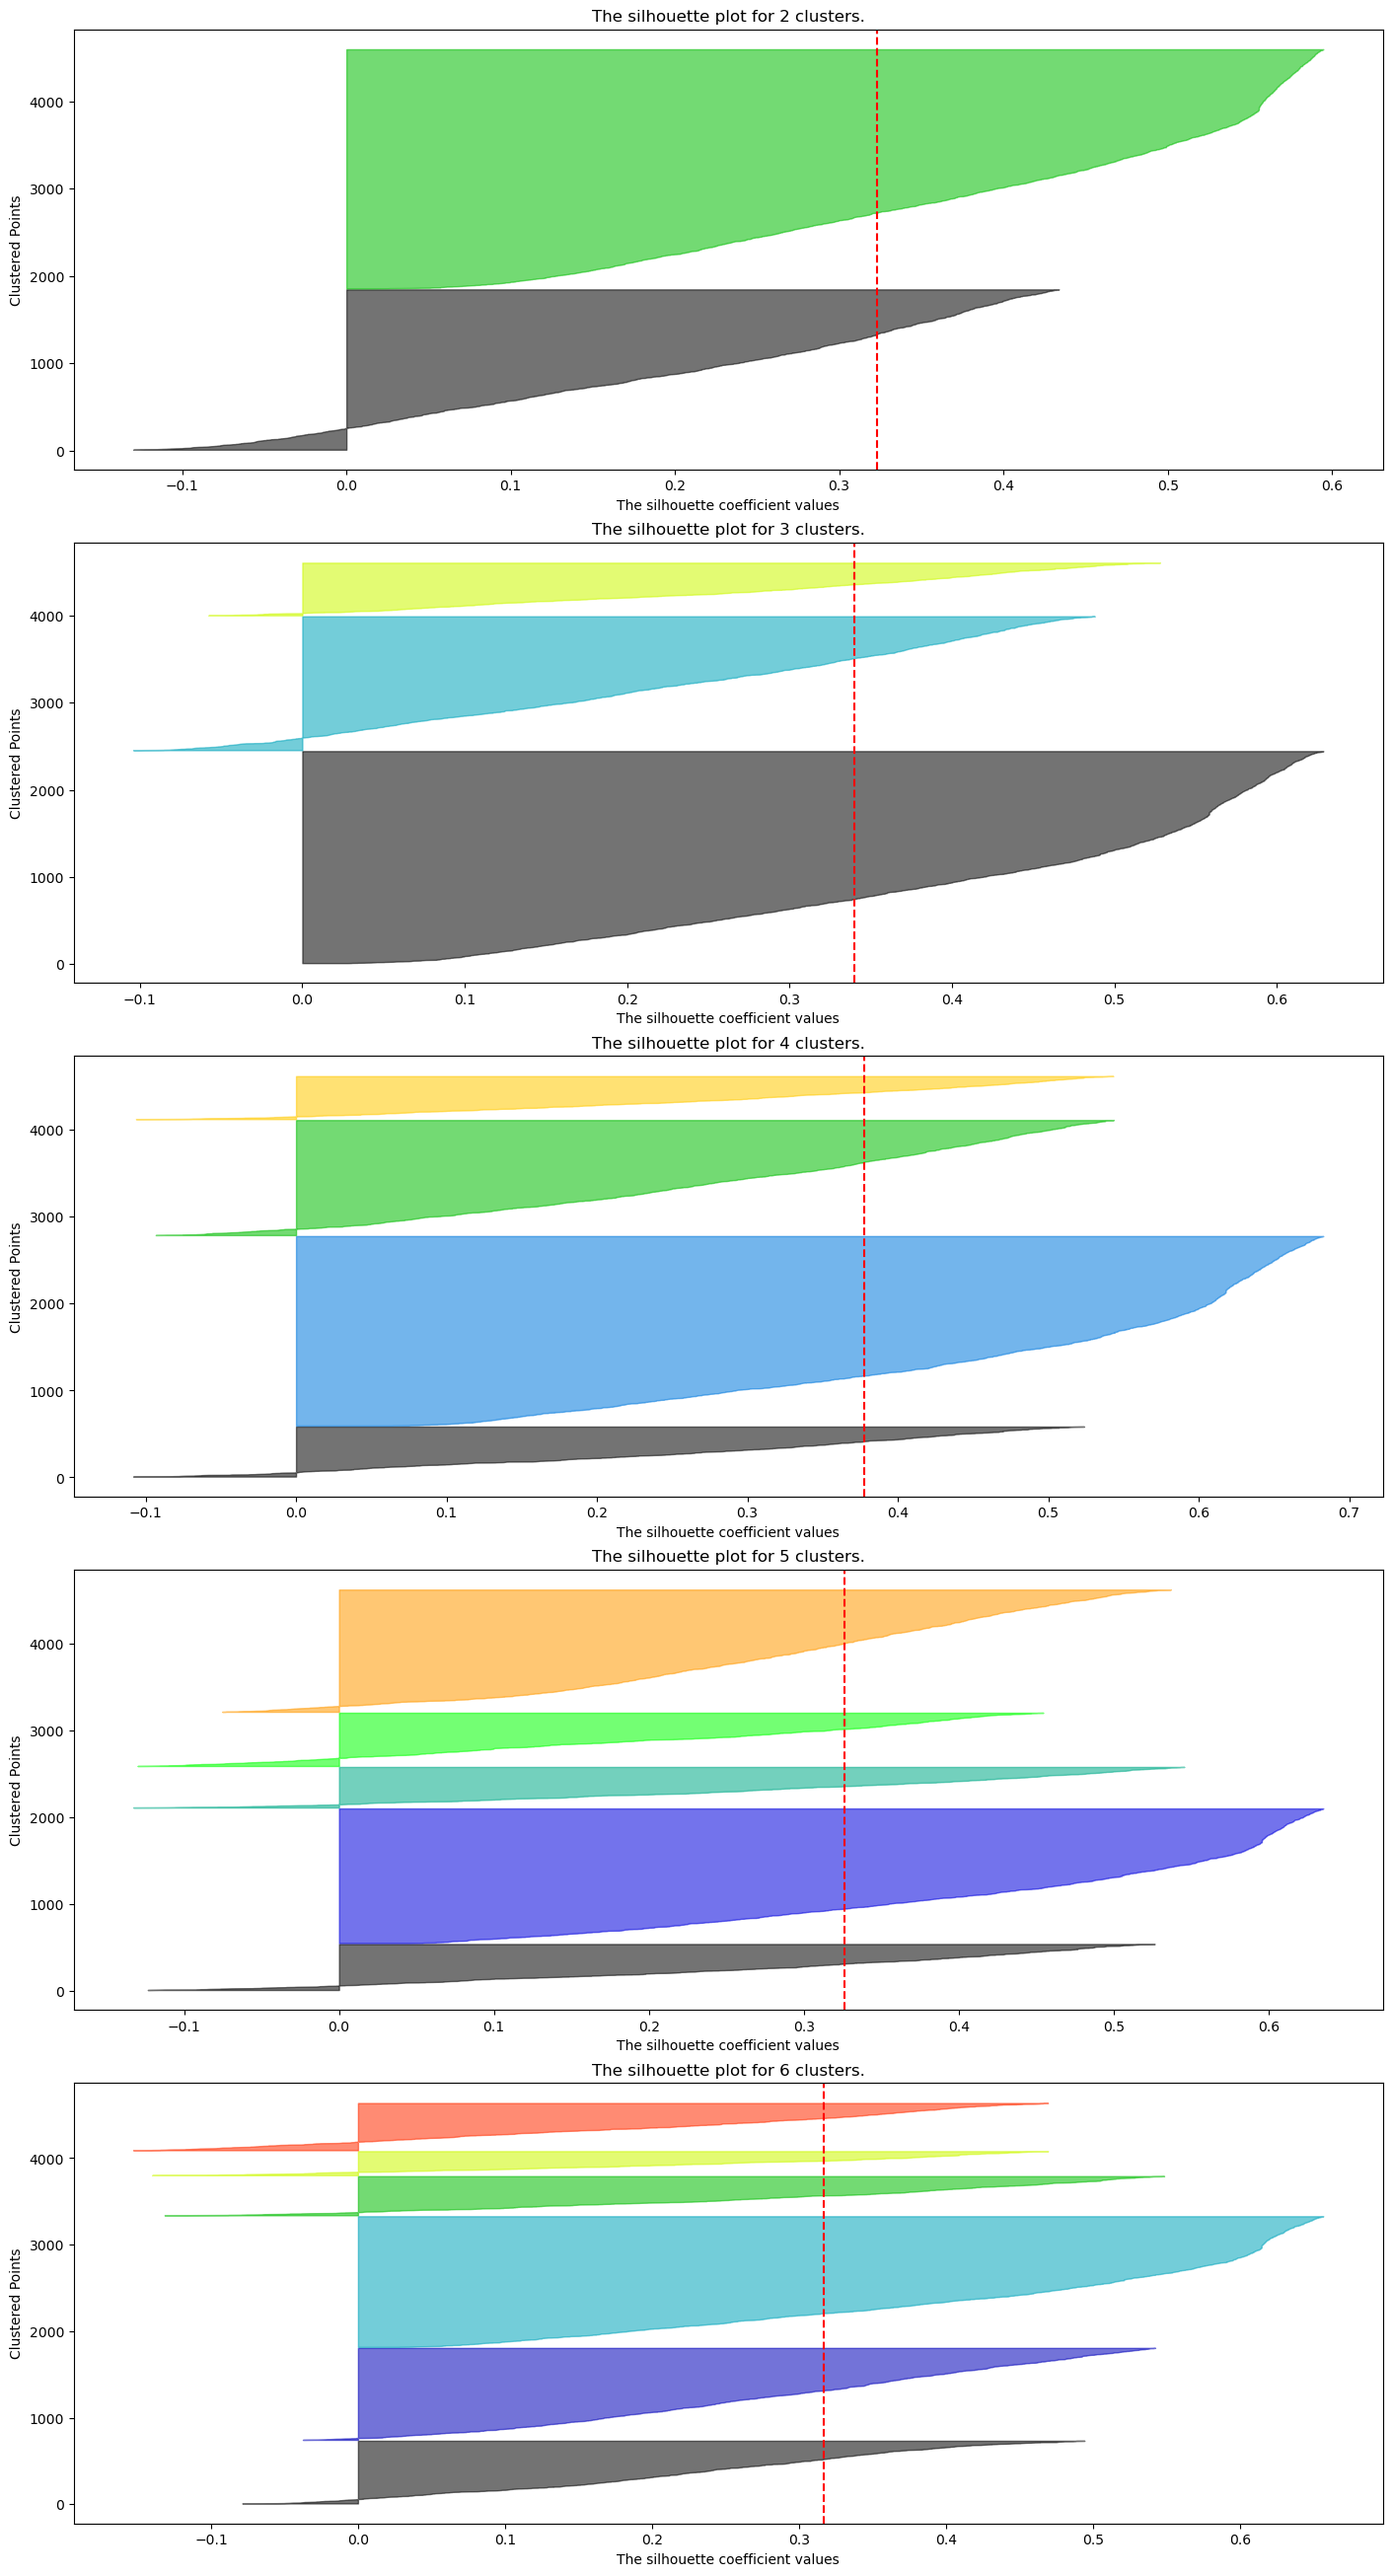

In [14]:
x = comments['comment'].astype('str')
analysis_trans = generate_model(x, ret_clu = False)

range_cluster = [*range(2,7)]
ex_silhouette_avg = []

fig, ax = plt.subplots(len(range_cluster), 1, constrained_layout=True, squeeze = False)
fig.set_size_inches(14, 26)

for count, num_clusters in enumerate(range_cluster):
    ex_km = KMeans(n_clusters=num_clusters)
    ex_cluster_labels = ex_km.fit_predict(analysis_trans[0])


    #gather silhouette_values
    ex_silhouette_values = silhouette_samples(analysis_trans[0], ex_cluster_labels)
    ex_silhouette_avg.append(silhouette_score(analysis_trans[0], ex_cluster_labels))

    #plot s
    y_lower = 10
    for idx_label in range(num_clusters):

        idx_cluster_silhouette_values = ex_silhouette_values[ex_cluster_labels == idx_label]

        idx_cluster_silhouette_values.sort()

        size_cluster_idx = idx_cluster_silhouette_values.shape[0]

        y_upper = size_cluster_idx + y_lower

        color = cm.nipy_spectral(float(idx_label) / num_clusters)

        ax[count, 0].fill_betweenx(np.arange(y_lower, y_upper),
                      0, idx_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.55)

        y_lower = y_upper + 10
    
    ax[count, 0].axvline(x=ex_silhouette_avg[count], color="red", linestyle="--")
    ax[count, 0].set_title(f"The silhouette plot for {num_clusters} clusters.")
    ax[count, 0].set_xlabel("The silhouette coefficient values")
    ax[count, 0].set_ylabel("Clustered Points")
    
    

local max indicates 4 is the optimal amount of clusters within the given range


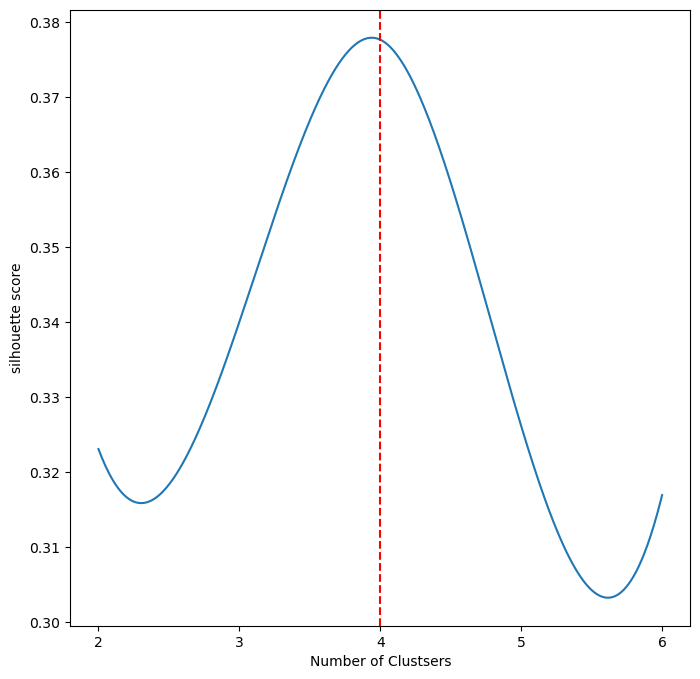

In [15]:
max_idx = argrelmax(np.array(ex_silhouette_avg))[0][0]

X_Y_Spline = make_interp_spline(range_cluster, ex_silhouette_avg )
 
# Returns evenly spaced numbers over a specified interval.
X_ = np.linspace(np.array(range_cluster).min(), np.array(range_cluster).max(), 500)
Y_ = X_Y_Spline(X_)

fig, ax1 = plt.subplots(figsize = (8,8))
ax1.plot(X_, Y_)
ax1.set_ylabel("silhouette score")

ax1.set_xticks(range_cluster)
ax1.set_xlabel("Number of Clustsers")
ax1.axvline(x=range_cluster[max_idx], color="red", linestyle="--")
    
print(f"local max indicates {range_cluster[max_idx]} is the optimal amount of clusters within the given range")

## Model for comments with 4 number of clusters

In [16]:
x = comments['comment'].astype('str')
process, cluster = generate_model(x)
comments_pca = generate_df(comments, process, cluster, 'comment')

# create csv file for clustered comments

# comments_pca.to_csv("data/clustered-data/clustered_comments.csv")

/home/pavel/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


## Silouhette analysis for posts

/home/pavel/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


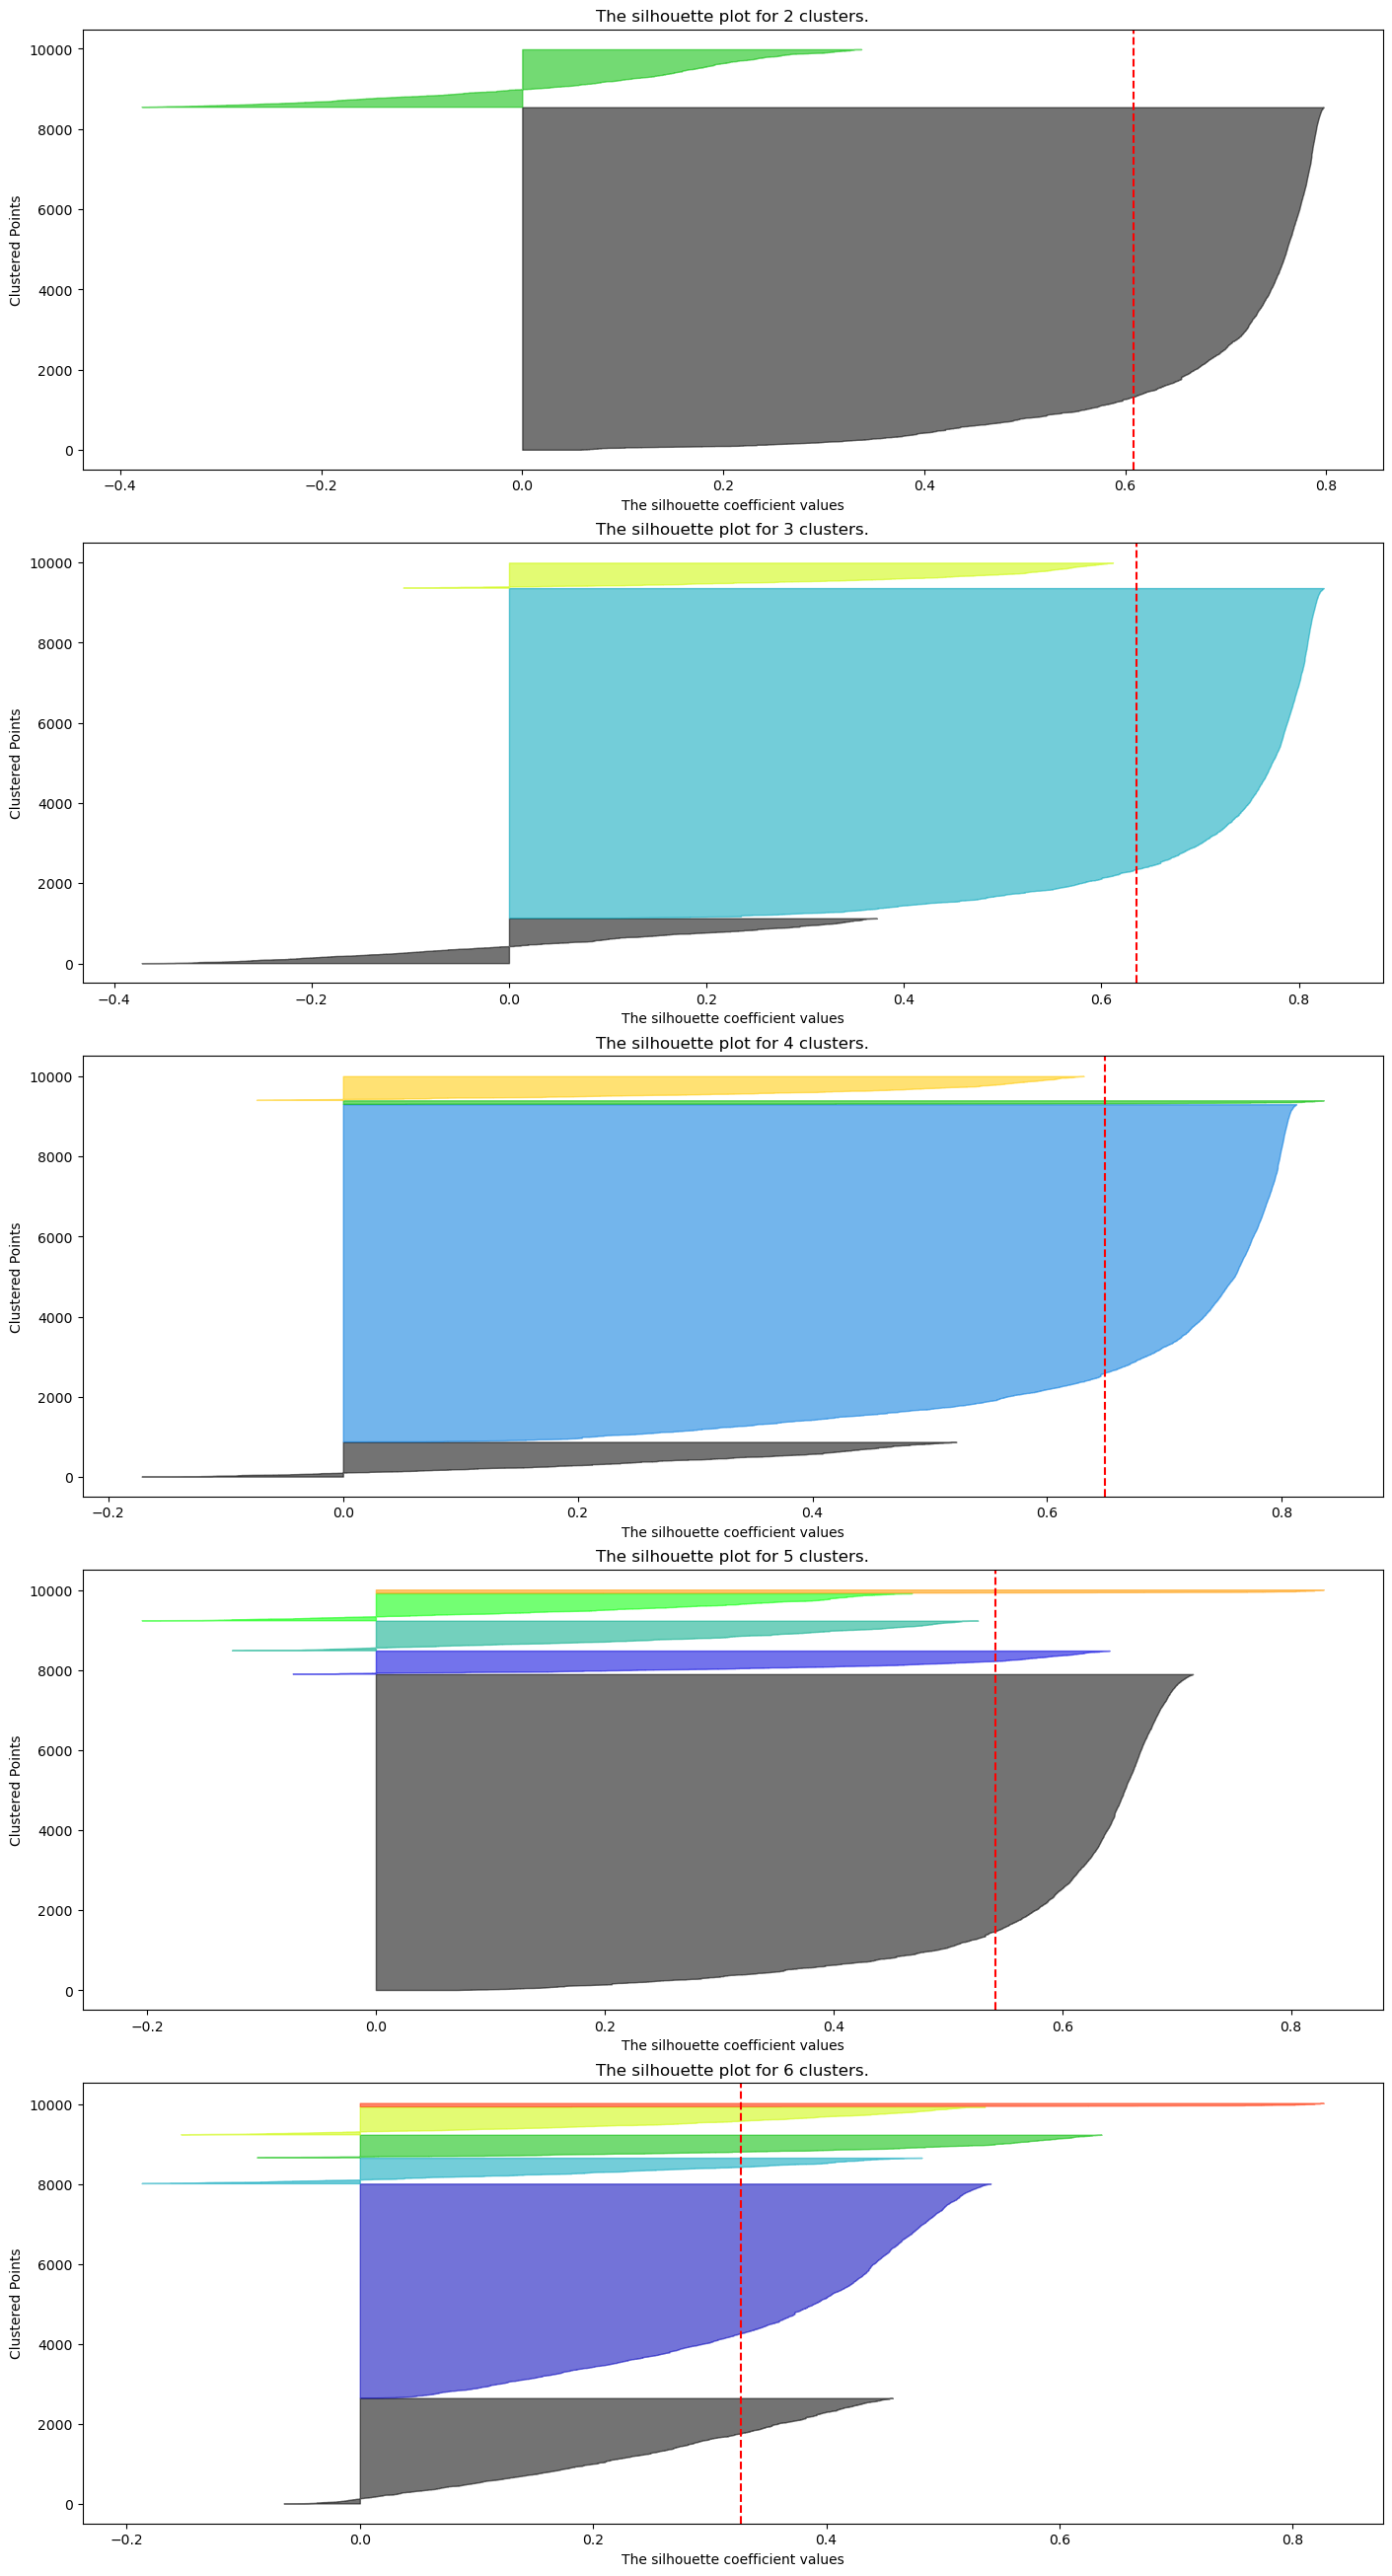

In [17]:
x = posts['title'].astype('str')
analysis_trans = generate_model(x, ret_clu = False)

range_cluster = [*range(2,7)]
ex_silhouette_avg = []

fig, ax = plt.subplots(len(range_cluster), 1, constrained_layout=True, squeeze = False)
fig.set_size_inches(14, 26)

for count, num_clusters in enumerate(range_cluster):
    ex_km = KMeans(n_clusters=num_clusters)
    ex_cluster_labels = ex_km.fit_predict(analysis_trans[0])


    #gather silhouette_values
    ex_silhouette_values = silhouette_samples(analysis_trans[0], ex_cluster_labels)
    ex_silhouette_avg.append(silhouette_score(analysis_trans[0], ex_cluster_labels))

    #plot s
    y_lower = 10
    for idx_label in range(num_clusters):

        idx_cluster_silhouette_values = ex_silhouette_values[ex_cluster_labels == idx_label]

        idx_cluster_silhouette_values.sort()

        size_cluster_idx = idx_cluster_silhouette_values.shape[0]

        y_upper = size_cluster_idx + y_lower

        color = cm.nipy_spectral(float(idx_label) / num_clusters)

        ax[count, 0].fill_betweenx(np.arange(y_lower, y_upper),
                      0, idx_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.55)

        y_lower = y_upper + 10
    
    ax[count, 0].axvline(x=ex_silhouette_avg[count], color="red", linestyle="--")
    ax[count, 0].set_title(f"The silhouette plot for {num_clusters} clusters.")
    ax[count, 0].set_xlabel("The silhouette coefficient values")
    ax[count, 0].set_ylabel("Clustered Points")

local max indicates 4 is the optimal amount of clusters within the given range


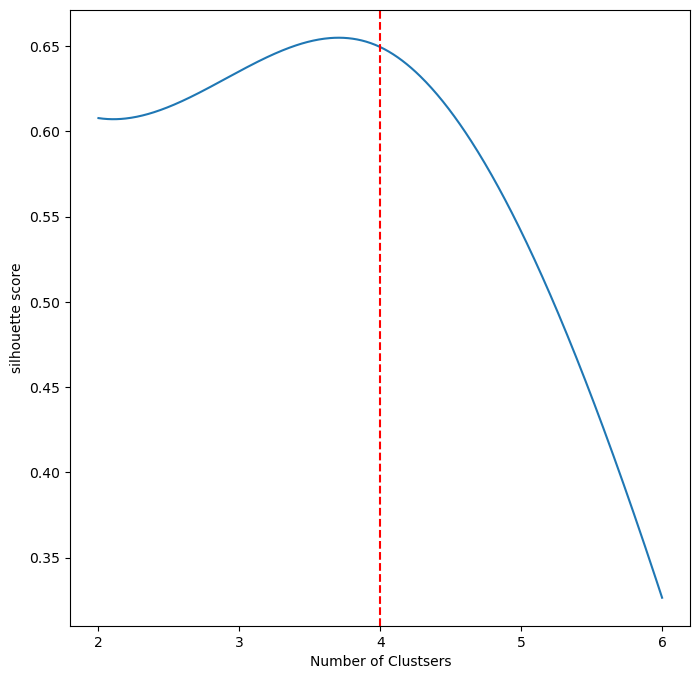

In [18]:
max_idx = argrelmax(np.array(ex_silhouette_avg))[0][0]

X_Y_Spline = make_interp_spline(range_cluster, ex_silhouette_avg )
 
# Returns evenly spaced numbers over a specified interval.
X_ = np.linspace(np.array(range_cluster).min(), np.array(range_cluster).max(), 500)
Y_ = X_Y_Spline(X_)

fig, ax1 = plt.subplots(figsize = (8,8))
ax1.plot(X_, Y_)
ax1.set_ylabel("silhouette score")

ax1.set_xticks(range_cluster)
ax1.set_xlabel("Number of Clustsers")
ax1.axvline(x=range_cluster[max_idx], color="red", linestyle="--")
    
print(f"local max indicates {range_cluster[max_idx]} is the optimal amount of clusters within the given range")

## Model for posts with 4 clusters

In [19]:
x = posts['title'].astype('str')
process, cluster = generate_model(x)
posts_pca = generate_df(posts, process, cluster, 'title')

# create csv file for clustered posts

# posts_pca.to_csv("data/clustered-data/clustered_posts.csv")

/home/pavel/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


## Plotting 3d clusters <br>
> The section below attempts to cluster the comments.

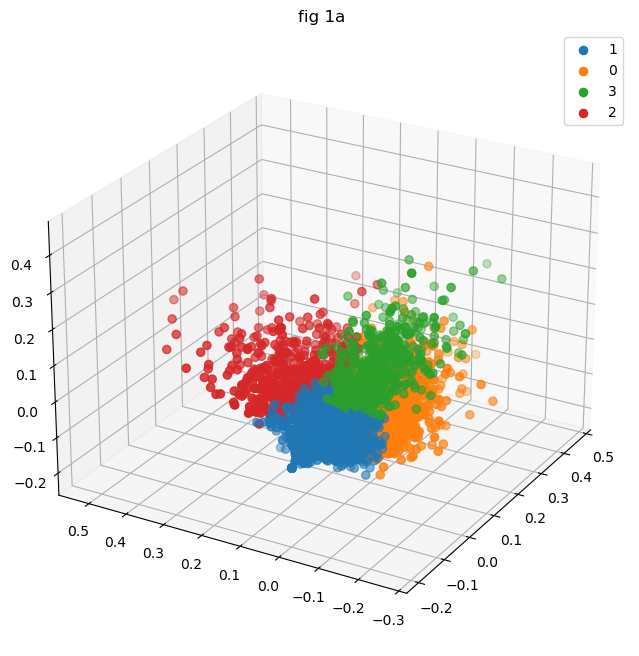

In [27]:
u_label = comments_pca['label'].unique()

plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')

for i in u_label:
    ax.scatter3D(comments_pca[comments_pca.label == i].iloc[:,0], comments_pca[comments_pca.label == i].iloc[:,1], comments_pca[comments_pca.label == i].iloc[:,2], s=35, label=i)

ax.legend()
ax.set_title('fig 1a')
ax.view_init(25, 210)

plt.savefig('assets/1a.png')


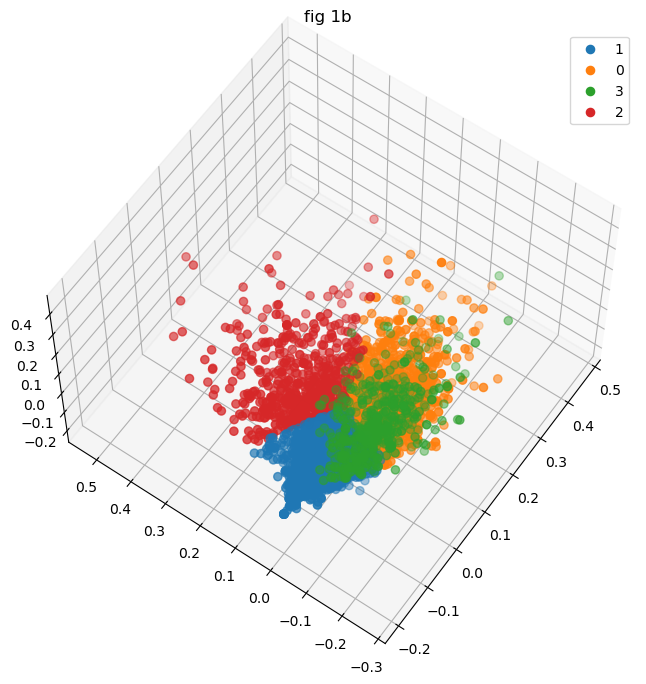

In [28]:
u_label = comments_pca['label'].unique()

plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')

for i in u_label:
    ax.scatter3D(comments_pca[comments_pca.label == i].iloc[:,0], comments_pca[comments_pca.label == i].iloc[:,1], comments_pca[comments_pca.label == i].iloc[:,2], s=35, label=i)

ax.legend()
ax.set_title('fig 1b')
ax.view_init(60, 215)

plt.savefig('assets/1b.png')

##### In the figures above, 2 angles of the same 3D scatter plot are given in order to better see the dimentions and clusters.<br>
> The section below attempts to cluster the posts.

In [15]:
x = posts['title'].astype('str')
process, cluster = generate_model(x)
posts_pca = generate_df(posts, process, cluster, 'title')

/home/pavel/Documents/concordia-bootcamps/Classes/ds-project-data-engineering-3/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


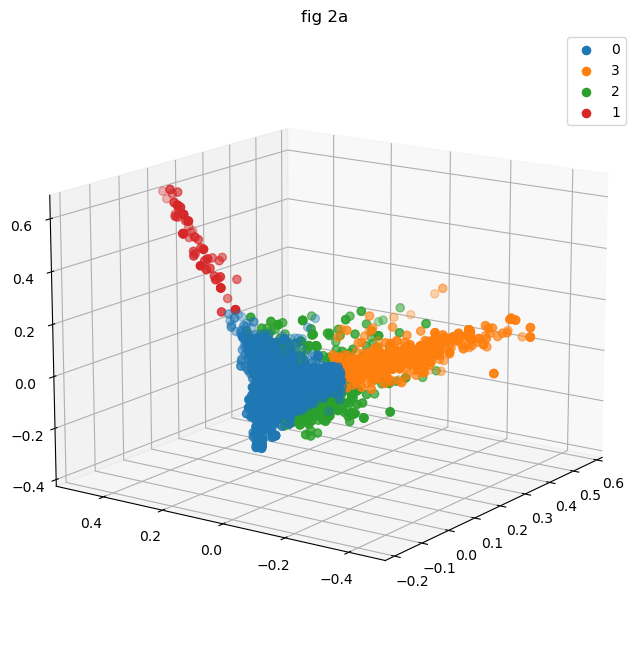

In [29]:
u_label = posts_pca['label'].unique()

plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')

for i in u_label:
    ax.scatter3D(posts_pca[posts_pca.label == i].iloc[:,0], posts_pca[posts_pca.label == i].iloc[:,1], posts_pca[posts_pca.label == i].iloc[:,2], s=35, label=i)

ax.legend()
ax.set_title('fig 2a')
ax.view_init(15, 215)

plt.savefig('assets/2a.png')


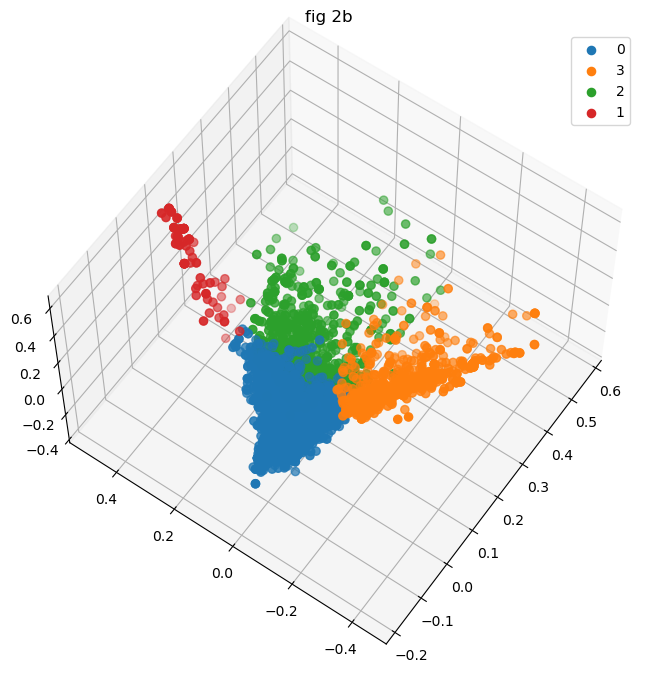

In [30]:
u_label = posts_pca['label'].unique()

plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')

for i in u_label:
    ax.scatter3D(posts_pca[posts_pca.label == i].iloc[:,0], posts_pca[posts_pca.label == i].iloc[:,1], posts_pca[posts_pca.label == i].iloc[:,2], s=35, label=i)

ax.legend()
ax.set_title('fig 2b')
ax.view_init(60, 215)

plt.savefig('assets/2b.png')

### Now that the clustering is complete<br>
> The section bellow will attempt to spot similarities between different clusters from posts and comments using human intuition on the text. <br>


We do not know if the same groups are similar to eachother from comments to posts.<br>
The counts bellow indicate the total amount of textual data in each group.

In [18]:
comments_pca = pd.read_csv("data/clustered-data/clustered_comments.csv", index_col=0)
posts_pca = pd.read_csv("data/clustered-data/clustered_posts.csv",index_col=0)

In [19]:
comments_pca

,pca1,pca2,pca3,label,text,score
0,-0.060135,-0.057581,-0.022636,0,Congrats on President elect Joe Biden for winn...,21260
1,0.120887,0.014335,-0.022497,1,The level of narcissism it takes to think that...,19822
2,-0.175342,-0.016400,-0.038617,0,Fuck,19726
3,0.055989,-0.058712,-0.062301,1,Direct quote from this guy Redistricting is li...,18723
4,0.071258,-0.029663,0.001310,1,Are you telling me that a cyber security speci...,17778
...,...,...,...,...,...,...
4573,-0.160630,0.000270,-0.030699,0,funny,1
4574,0.068910,0.044645,0.048063,3,Exactly It s not a technical issue that preven...,1
4575,-0.033348,-0.007100,-0.083649,0,And now they can t plead the fifth let s hope ...,1
4576,0.082822,-0.057728,0.037021,1,We re going to find out Trump took active meas...,1


In [20]:
# Counting the amount of posts or comments are present in each label

comments_groups = comments_pca['label'].value_counts().rename('comments_labels')
posts_groups = posts_pca['label'].value_counts().rename('posts_labels')

all_groups = pd.concat([comments_groups, posts_groups], axis=1)
all_groups

,comments_labels,posts_labels
0,2182,864
1,1326,87
3,570,595
2,500,8420


In the counts above, group 0 appear to have more data than other groups.

In [21]:
pd.set_option('max_colwidth', 600)

In [22]:
SAMPLES = 10

comments_samples = pd.DataFrame()
posts_samples = pd.DataFrame()

for i in range(len(all_groups)):
    comments_group = comments_pca.loc[comments_pca['label'] == i]['text'].rename(f'Group{i}').sample(SAMPLES).reset_index(drop='Index')
    posts_group = posts_pca.loc[posts_pca['label'] == i]['text'].rename(f'Group{i}').sample(SAMPLES).reset_index(drop='Index')

    comments_samples = pd.concat([comments_samples,comments_group],axis=1)
    posts_samples = pd.concat([posts_samples,posts_group],axis=1)


In [23]:
comments_samples

,Group0,Group1,Group2,Group3
0,why are democrats distraught about this aren t old people more of republican demographic,Can I just say hearing someone running for office openly admit that they didn t have the proper expertise to advocate for an issue so they deferred to experts who could do the job is refreshing Good luck to you from NYC,Right For 75 years he was not a millionaire Then he nefariously writes a book makes money from it and wants to raises his own taxes to pay for the policies he champions for the 99 Pish what a hypocrite The worst I tell you,If you don t think democrats fuck people you re blind They just don t do it as openly as republicans do
1,A serial killer as their influencer because life is so very precious to republicans,This is tough for Dems They really want this to turn into a war so they can blame Trump for something but they also don t want a war,No way Trump won t respond he s going to authorize a strike inside Iran and then that s war folks,What are you talking about It s MONEY At any cost
2,Yes so many right wing groups attacking people mindlessly and rioting,Not necessarily true Your source is AOC interpreting national security protocols writing that if she didn t take the vaccine there s a chance it could have just been stored There might be a threshold for how much vaccine the federal government holds on to and the rest is distributed We just don t know,He was just trying to prove how easy it is to cheat and now the deep state is punishing him for it,How do you confidently make a claim like that and not think of how any form of invalid vote in a big enough scale can affect outcomes Even though you are told it s not in this situation The fact that this is possible and has happened for God knows how long and your okay with it shows you have too much faith in the government and believe whatever they say or you re okay with obvious holes in our electorial system which puts people in the highest form of power in our government Turning a blind eye to these obvious flaws because you personally don t think it affects anything is being naive
3,Personal insults can result in a permanent ban,Was Bernie a likely nominee from the beginning He wasn t that far from the nomination in 2016 and was the favorite until Biden entered the race,Trump needs to capitalize on this I don t wish death on anybody but it was clear her time has come Trump needs more control and power To make up for the Democrats sabotaging his presidency with that phony impeachment,Eh she hasn t made any point on not taking it for a reason other than others should get it first People that like Ilhan are not folks who instantly think oh if she didn t get it it must be a conspiracy and the vaccine is poison
4,That isn t the controversial statement The controversial parts are the spirit murder etc,It ll make a few people who don t live on the border kind of happy for a week Then they ll just use it to win pretty arguments with themselves,Jesus Christ liberals are pitiful No he will not ever be a global superhero He s just one of the many many rats fleeing a sinking ship desperate for a book deal Fuck him and everyone that ever enabled this administration forever,You can t keep a thought for more than one second m can you We are talking about how amazon hasn t done what the Bernie people want Stay on topic or I m gone
5,Iowan here damn i hate her,Heck what about all the at risk groups that are literally dying due to not having the vaccine The US is the only country in the world where the rich and powerful get to go ahead of the queue,This is why nobody trust politcal hack media outlets like the HuffPo Trump didn t blame Biden for not instituting a mask mandate He said the Democrats who currently control the House said they were going to institute a mask mandate which they haven t done Trump was asked Why don t you support a mask mandate and why don t you wear one more often And his answer was Well I do wear them when I have to and when I m in ho

From these comment 

In [24]:
posts_samples

,Group0,Group1,Group2,Group3
0,Relief bill slips to Sunday Chances,Congressman elect Luke Letlow 41 dies with coronavirus,Trump presents PM Modi with top US honour Legion Of Merit,McConnell blocks Schumer s bid to unanimously pass 2 000 stimulus checks
1,McConnell thanks Trump for signing coronavirus relief bill,Republican Louisiana Congressman elect Luke Letlow dies from COVID,Outgoing Barr breaks with Trump again on alleged Russia hack voter fraud,Dems Say They ll Hold Vote On 2 000 Checks Monday As GOP Rejects First Attempt
2,Congress Reaches Agreement on 900 Billion COVID 19 Relief Package,Congressman elect Luke Letlow dies after battling Covid 19,Law Professor Wants All Black Votes To Count Twice Because Voting Once Is Racist,Second Stimulus Check Update Families With Undocumented Members Eligible For 600 Payments
3,After pressure from lawmakers Trump suggests he may take action on relief bill,Louisiana congressman elect Luke Letlow dies from COVID 19 at 41,More Americans than ever distrust the news here s why and what to do about it,Senate GOP blocks Democratic push for Trump s 2K checks
4,What s next after Trump blasts virus relief bill,Congressman elect Luke Letlow dies after battling Covid 19,STOPDMCA,Trump threatens to torpedo COVID relief with new demands requests 2 000 stimulus checks
5,Trump signs 2 3T relief spending package,Congressman elect Luke Letlow dies after Covid diagnosis,Trump Campaign Files New Petition With Supreme Court To Overturn Pa Election Results,McConnell blocks Democrats attempt to quickly approve 2 000 stimulus checks amid pressure on GOP to act
6,President Trump Signs Pandemic Relief Bill,Louisiana Congressman Elect Rep Luke Letdown dies of Covid 19,Dominion worker sues Trump campaign and conservative media,Donald Trump threatens to VETO relief bill demanding Congress increase checks from 600 to 2 000
7,Fauci to get Covid 19 vaccine on Tuesday,Luke Letlow 41 year old congressman elect dies with COVID 19,Covid 19 catch 22 Regime change policies come packed with US pandemic relief The Grayzone,House Republicans Leak McCarthy s Effort to Kill 2 000 Checks
8,Trump signs massive measure funding government COVID relief,Louisiana Congressman elect Luke Letlow dies with COVID,Mitch McConnell says leadership finalized 900 billion coronavirus deal,Americans will get stimulus checks as soon as next week Mnuchin says
9,Trump threatens COVID relief bill testing loyalty of GOP,Louisiana Rep elect Luke Letlow dies of COVID 19,OBJECTION Florida Lawyer Says Rep Matt Gaetz Should be Disbarred for Act of Sedition,This week on the Senate floor Mitch McConnell wants to vote to override Trump s veto of the 740 billion defense funding bill and then head home for the New Year I m going to object until we get a vote on legislation to provide a 2 000 direct payment to the working class


## Comments findings:
There appears to be no clear differences between the groups, as well as no clear similarity between posts and comments groups.<br>
This could be due to the model not being complete enough as well as the dimentionality reduction taking away too much information from language.<br>
If there are any differences and similarities, they are not apparent to a human's intuition. It is also not possible to see why the model made the groups that it did.

## Posts findings:

- Group 0 : Too vague

- Group 1 : $2000 stimulus checks

- Group 2 : Trump signing bills

- Group 4 : Political figure dies from COVID 19



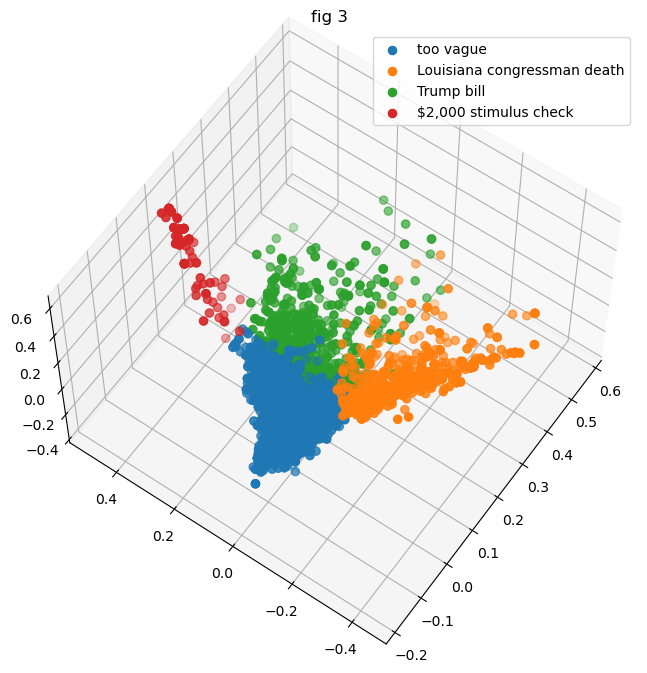

In [34]:
# Label posts clusters from our findings

new_label = {0:'Too vague', 1:'$2,000 stimulus check', 2:'Trump bill', 3:'Louisiana congressman death'}
posts_pca.replace({'label':new_label}, inplace=True)

u_label = posts_pca['label'].unique()

plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')

for i in u_label:
    ax.scatter3D(posts_pca[posts_pca.label == i].iloc[:,0], posts_pca[posts_pca.label == i].iloc[:,1], posts_pca[posts_pca.label == i].iloc[:,2], s=35, label=i)

ax.legend()
ax.set_title('fig 3')
ax.view_init(60, 215)

plt.savefig('assets/3.png')

### A final examination.
According to the 3D scatter plot of posts. There seems to be a significant difference between group 2 and group 4.

In [40]:
posts_group2 = posts_pca.loc[posts_pca['label'] == new_label[1]]['text'].sample(10).reset_index(drop='index').rename(new_label[3])
posts_group4 = posts_pca.loc[posts_pca['label'] == new_label[3]]['text'].sample(10).reset_index(drop='index').rename(new_label[1])

posts_group_2_4 = pd.concat([posts_group2,posts_group4], axis=1)

posts_group_2_4

,Louisiana congressman death,"$2,000 stimulus check"
0,Louisiana congressman elect dies of Covid,Most Americans to receive 600 coronavirus relief checks starting next week
1,Congressman elect Luke Letlow dies from Covid complications days before being sworn in,Second stimulus check Will you get 2 000 600 or nothing
2,Louisiana congressman elect Luke Letlow dies at 41 of COVID 19 complications,Congress agrees to 900 billion coronavirus stimulus deal McConnell says
3,Luke Letlow GOP congressman elect from Louisiana dies of covid 19,Senate passes stimulus bill sends to Trump for signature
4,Louisiana congressman elect dies of Covid,Stimulus check update as House Republicans block 2 000 Plan Trump golfs
5,Luke Letlow Newly elected US lawmaker 41 dies from Covid,Bernie Sanders on the battle to increase stimulus payments
6,Louisiana Congressman elect Luke Letlow dies at 41 from COVID 19,Donald Trump presses Senate on 2 000 stimulus checks says people have suffered enough
7,Congressman elect Luke Letlow dies after Covid diagnosis,McConnell blocks Democrats attempt to quickly approve 2 000 stimulus checks amid pressure on GOP to act
8,Congressman elect Luke Letlow dead after battle with coronavirus,Celebs React to Mitch McConnell Blocking Call for Unanimous Vote for 2K Stimulus Checks
9,Congressman elect Luke Letlow dies after battling Covid 19,Pelosi says House to vote on bigger stimulus payments after GOP blocks increase


### Findings:
Group 2 contains 84 entries. <br>
It seems to have a disproportional amount of posts containing "Louisiana", "Congressmen", and Covid19.<br>
From experimenting with different samples, some identical posts show up a lot.<br>
<br>
Group 4 contains 576 entries <br>
It seems to have a disproportional amount of posts containing "Trump", "McConnell", as well as topics words related to stimulus checks. Some other politicians names appear occasionnaly as well.

# Results:
There appears to be no evident differences or similarities betweem different clusters of either posts or comments.<br>
Two groups appear to stand out compared to others groups. Those were groups 2 and 4 for the posts.<br>
From human analysis, we have found that group 2 can some what find posts about Louisiana, as they are low in number compared to other clusters, but there is not enough evidence or metrics to base ourselves on to prove that.<br>
<br>
There are many things to consider as to why we found the results that we did. We have chosen an arbitrary set of 10_000 entries, but there is no way to determine how those entries were picked from the Pushshift API. We do not know if the selection process was random, in series, or based on some other metrics that we do not have control over.<br>
Due to the TFIDF Vectorizer using the amount of times some words appear as metrics, there could be flaws in those metrics as we did not filter for reposts or bots posting the same text multiple time, skewing our results. Therefore it is hard to conclude anything.